In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from os import listdir, walk
from os.path import isfile, join

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

'''알고리즘 관련 라이브러리'''
from kshape.core import kshape, zscore
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import hdbscan

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.
C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])
data_train = np.loadtxt(current_path+file+
                        "ECGFiveDays/ECGFiveDays_TRAIN", 
                        delimiter=",")
X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)

data_test = np.loadtxt(current_path+file+
                       "ECGFiveDays/ECGFiveDays_TEST", 
                       delimiter=",")
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [3]:
# 기본 요약 통계
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 23
Number of unique classes: 2
Time series length: 136


In [4]:
# 훈련 셋에서 각 클래스별 샘플 수
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))

Number of time series in class 1.0: 14
Number of time series in class 2.0: 9


Plot  0  Class  1.0


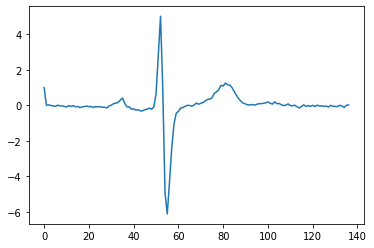

Plot  1  Class  1.0


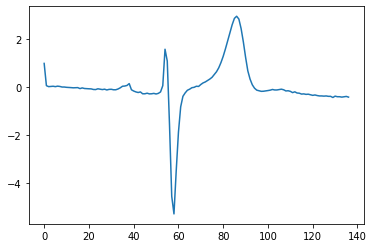

Plot  4  Class  1.0


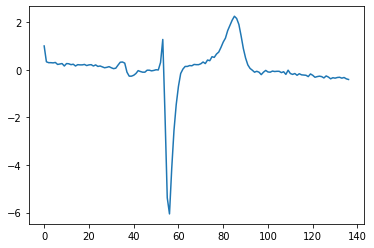

Plot  7  Class  1.0


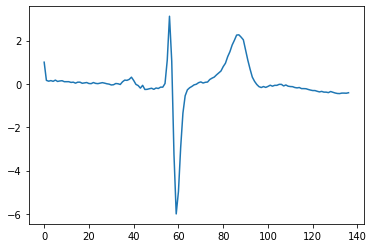

Plot  9  Class  1.0


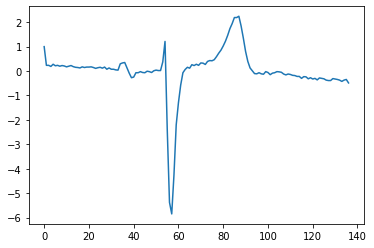

In [5]:
# 클래스 1.0 인 샘플
for i in range(0,10):
    if data_train[i,0]==1.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

Plot  2  Class  2.0


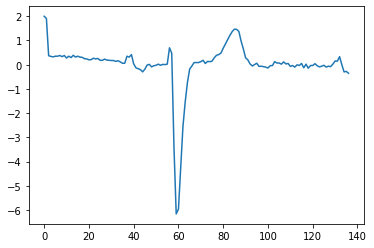

Plot  3  Class  2.0


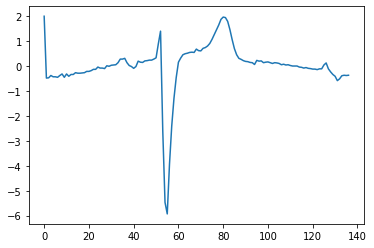

Plot  5  Class  2.0


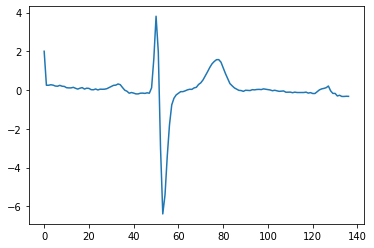

Plot  6  Class  2.0


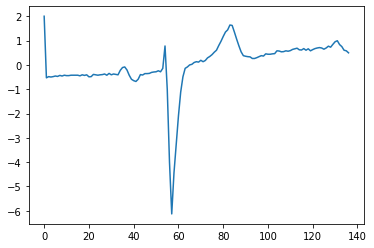

Plot  8  Class  2.0


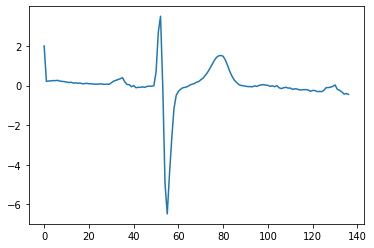

In [6]:
# 클래스 2.0의 샘플
for i in range(0,10):
    if data_train[i,0]==2.0:
        print("Plot ",i," Class ",data_train[i,0])
        plt.plot(data_train[i])
        plt.show()

In [7]:
# 데이터 준비 - 스케일
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [8]:
# k-Shape 알고리즘

In [9]:
# k-Shape를 사용한 훈련
ks = KShape(n_clusters=2, max_iter=100, n_init=100,verbose=0)
ks.fit(X_train)

KShape(init='random', max_iter=100, n_clusters=2, n_init=100, random_state=None,
       tol=1e-06, verbose=0)

In [10]:
# 훈련 셋의 예측값 생성 및 수정된 Rand 지수 계산
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index:", ars)

Adjusted Rand Index: 0.668041237113402


In [11]:
# 테스트 셋의 예측값 생성 및 수정된 Rand 지수 계산
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.00038104664587699784


In [12]:
# ECG 5000

In [13]:
## 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])
data_train = np.loadtxt(current_path+file+
                        "ECG5000/ECG5000_TRAIN", 
                        delimiter=",")

data_test = np.loadtxt(current_path+file+
                       "ECG5000/ECG5000_TEST", 
                       delimiter=",")

data_joined = np.concatenate((data_train,data_test),axis=0)
data_train, data_test = train_test_split(data_joined, 
                                    test_size=0.20, random_state=2019)

X_train = to_time_series_dataset(data_train[:, 1:])
y_train = data_train[:, 0].astype(np.int)
X_test = to_time_series_dataset(data_test[:, 1:])
y_test = data_test[:, 0].astype(np.int)

In [14]:
# 요약 통계
print("Number of time series:", len(data_train))
print("Number of unique classes:", len(np.unique(data_train[:,0])))
print("Time series length:", len(data_train[0,1:]))

Number of time series: 4000
Number of unique classes: 5
Time series length: 140


In [15]:
# 클래스별 샘플 수 계산
print("Number of time series in class 1.0:", 
      len(data_train[data_train[:,0]==1.0]))
print("Number of time series in class 2.0:", 
      len(data_train[data_train[:,0]==2.0]))
print("Number of time series in class 3.0:", 
      len(data_train[data_train[:,0]==3.0]))
print("Number of time series in class 4.0:", 
      len(data_train[data_train[:,0]==4.0]))
print("Number of time series in class 5.0:", 
      len(data_train[data_train[:,0]==5.0]))

Number of time series in class 1.0: 2327
Number of time series in class 2.0: 1423
Number of time series in class 3.0: 75
Number of time series in class 4.0: 156
Number of time series in class 5.0: 19


 Class  1.0  Count  2327


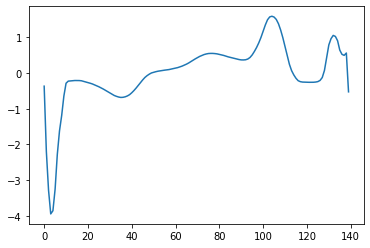

 Class  2.0  Count  1423


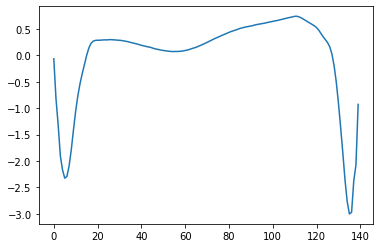

 Class  3.0  Count  75


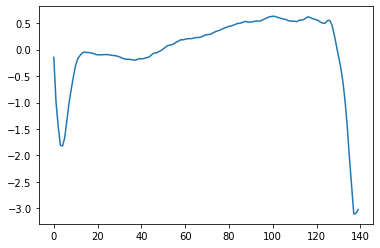

 Class  4.0  Count  156


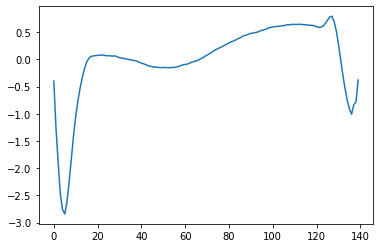

 Class  5.0  Count  19


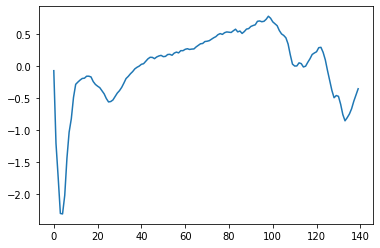

In [16]:
# 각 클래스별 수치값 보기
for j in np.unique(data_train[:,0]):
    dataPlot = data_train[data_train[:,0]==j]
    cnt = len(dataPlot)
    dataPlot = dataPlot[:,1:].mean(axis=0)
    print(" Class ",j," Count ",cnt)
    plt.plot(dataPlot)
    plt.show()

In [17]:
# 데이터 준비 - 스케일
X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(X_test)

In [18]:
# k-Shape를 사용한 훈련
ks = KShape(n_clusters=5, max_iter=100, n_init=10,verbose=1,random_state=2019)
ks.fit(X_train)

Init 1
0.015 --> 0.015 --> 
Init 2
0.014 --> 0.014 --> 
Init 3
0.018 --> 0.017 --> 0.018 --> 
Init 4
0.017 --> 0.016 --> 0.018 --> 
Init 5
0.016 --> 0.017 --> 
Init 6
0.012 --> 0.012 --> 
Init 7
0.016 --> 0.014 --> 0.016 --> 
Init 8
0.015 --> 0.014 --> 0.015 --> 
Init 9
0.017 --> 0.017 --> 0.018 --> 
Init 10
0.015 --> 0.016 --> 


KShape(init='random', max_iter=100, n_clusters=5, n_init=10, random_state=2019,
       tol=1e-06, verbose=1)

In [19]:
# 훈련 셋에 대한 예측값 생성 및 수정된 Rand 지수 계산
preds = ks.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.5553639462811412


In [20]:
# 테스트 셋에 대한 예측값 생성 및 수정된 Rand 지수 계산
preds_test = ks.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.5301670526070555


In [21]:
# 군집별 적합도 검정
preds_test = preds_test.reshape(1000,1)
preds_test = np.hstack((preds_test,data_test[:,0].reshape(1000,1)))
preds_test = pd.DataFrame(data=preds_test)
preds_test = preds_test.rename(columns={0: 'prediction', 1: 'actual'})

counter = 0
for i in np.sort(preds_test.prediction.unique()):
    print("Predicted Cluster ", i)
    print(preds_test.actual[preds_test.prediction==i].value_counts())
    print()
    cnt = preds_test.actual[preds_test.prediction==i] \
                        .value_counts().iloc[1:].sum()
    counter = counter + cnt
print("Count of Non-Primary Points: ", counter)

Predicted Cluster  0.0
2.0    127
3.0      9
4.0      6
5.0      1
Name: actual, dtype: int64

Predicted Cluster  1.0
2.0    197
1.0     18
4.0      9
3.0      3
Name: actual, dtype: int64

Predicted Cluster  2.0
4.0    18
2.0    18
5.0     3
1.0     2
3.0     2
Name: actual, dtype: int64

Predicted Cluster  3.0
1.0    130
3.0      3
4.0      2
5.0      1
2.0      1
Name: actual, dtype: int64

Predicted Cluster  4.0
1.0    442
3.0      4
4.0      3
2.0      1
Name: actual, dtype: int64

Count of Non-Primary Points:  86


In [22]:
# 시계열 k-평균

In [23]:
# 시계열 k-평균을 사용한 훈련
km = TimeSeriesKMeans(n_clusters=5, max_iter=100, n_init=100, \
                      metric="euclidean", verbose=1, random_state=2019)
km.fit(X_train)

Init 1
36.241 --> 27.298 --> 26.273 --> 25.556 --> 25.120 --> 24.911 --> 24.831 --> 24.815 --> 24.813 --> 24.812 --> 24.812 --> 24.812 --> 24.812 --> 
Init 2
37.226 --> 25.264 --> 24.680 --> 24.430 --> 24.296 --> 24.202 --> 24.155 --> 24.136 --> 24.128 --> 24.124 --> 24.121 --> 24.119 --> 24.118 --> 24.117 --> 24.117 --> 24.117 --> 24.117 --> 24.116 --> 24.116 --> 24.116 --> 24.116 --> 24.115 --> 24.115 --> 24.115 --> 24.114 --> 24.113 --> 24.112 --> 24.111 --> 24.110 --> 24.109 --> 24.108 --> 24.108 --> 24.108 --> 
Init 3
33.738 --> 25.341 --> 25.014 --> 24.795 --> 24.664 --> 24.623 --> 24.616 --> 24.615 --> 24.614 --> 24.614 --> 24.614 --> 


TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=100,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=5, n_init=3, n_jobs=None,
                 random_state=2019, tol=1e-06, verbose=1)

In [24]:
# 훈련 셋에 대한 예측값 생성 및 수정된 Rand 지수를 사용한 평가
preds = km.predict(X_train)
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index of Time Series k-Means on Training Set:", ars)

Adjusted Rand Index of Time Series k-Means on Training Set: 0.4377619210784641


In [25]:
# 테스트 셋에 대한 예측값 생성 및 수정된 Rand 지수를 사용한 평가
preds_test = km.predict(X_test)
ars = adjusted_rand_score(data_test[:,0],preds_test)
print("Adjusted Rand Index of Time Series k-Means on Test Set:", ars)

Adjusted Rand Index of Time Series k-Means on Test Set: 0.4176053162699025


In [26]:
# HDBCAN 

In [27]:
# 훈련 모델 및 테스트 셋에 대한 평가
min_cluster_size = 5
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'
prediction_data = True

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                      min_samples=min_samples, alpha=alpha, \
                      cluster_selection_method=cluster_selection_method, \
                      prediction_data=prediction_data)

preds = hdb.fit_predict(X_train.reshape(4000,140))
ars = adjusted_rand_score(data_train[:,0],preds)
print("Adjusted Rand Index on Training Set:", ars)

Adjusted Rand Index on Training Set: 0.7689563655060421


In [28]:
# 테스트 셋에 대한 예측값 생성 및 평가
preds_test = hdbscan.prediction.approximate_predict( \
                hdb, X_test.reshape(1000,140))
ars = adjusted_rand_score(data_test[:,0],preds_test[0])
print("Adjusted Rand Index on Test Set:", ars)

Adjusted Rand Index on Test Set: 0.7200816245545564


In [29]:
# 시계열 클러스터링 알고리즘 비교를 위한 실험

In [30]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'ucr_time_series_data', ''])

mypath = current_path + file
d = []
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    for i in dirnames:
        newpath = os.path.sep.join([mypath, i, ""])
        onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
        f.extend(onlyfiles)
    d.extend(dirnames)
    break

In [31]:
# k-Shpae 실험 - 전체 실행

In [32]:
# 데이터 프레임 생성
kShapeDF = pd.DataFrame(data=[],index=[v for v in d], \
                        columns=["Train ARS","Test ARS"])

In [33]:
# k-Shape 훈련 및 평가
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))
        return (time.time() - self.start_time)

timer = ElapsedTimer()
cnt = 0
for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                        test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(data_train[:, 1:])
    y_train = data_train[:, 0].astype(np.int)
    X_test = to_time_series_dataset(data_test[:, 1:])
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    ks = KShape(n_clusters=classes, max_iter=10, n_init=3,verbose=0)
    ks.fit(X_train)

    print(i)
    preds = ks.predict(X_train)
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kShapeDF.loc[i,"Train ARS"] = ars
    
    preds_test = ks.predict(X_test)
    ars = adjusted_rand_score(data_test[:,0],preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kShapeDF.loc[i,"Test ARS"] = ars
    
kShapeTime = timer.elapsed_time()

Dataset  1
50words
Adjusted Rand Index on Training Set: 0.30711303213673186
Adjusted Rand Index on Test Set: 0.24576686623212005
Dataset  2
Adiac
Adjusted Rand Index on Training Set: 0.06560933163855637
Adjusted Rand Index on Test Set: 0.06708773252358348
Dataset  3
ArrowHead
Adjusted Rand Index on Training Set: 0.02181630338438927
Adjusted Rand Index on Test Set: -0.01958293638192016
Dataset  4
Beef
Adjusted Rand Index on Training Set: 0.11381548330923084
Adjusted Rand Index on Test Set: 0.024630541871921187
Dataset  5
BeetleFly
Adjusted Rand Index on Training Set: -0.01693922382230897
Adjusted Rand Index on Test Set: -0.08247422680412367
Dataset  6
BirdChicken
Adjusted Rand Index on Training Set: 0.06812414600819829
Adjusted Rand Index on Test Set: 0.4948453608247423
Dataset  7
Car
Adjusted Rand Index on Training Set: 0.17914423783928315
Adjusted Rand Index on Test Set: 0.1453382699427802
Dataset  8
CBF
Adjusted Rand Index on Training Set: 0.7290472583195416
Adjusted Rand Index on Te

ShapesAll
Adjusted Rand Index on Training Set: 0.3970836997949536
Adjusted Rand Index on Test Set: 0.42305224151308135
Dataset  63
SmallKitchenAppliances
Adjusted Rand Index on Training Set: 0.005320105826260555
Adjusted Rand Index on Test Set: -0.008175872749137216
Dataset  64
SonyAIBORobotSurface
Adjusted Rand Index on Training Set: 0.16377617556008536
Adjusted Rand Index on Test Set: 0.20239620755920226
Dataset  65
SonyAIBORobotSurfaceII
Adjusted Rand Index on Training Set: 0.3499371979453356
Adjusted Rand Index on Test Set: 0.37789901716414376
Dataset  66
StarLightCurves
Adjusted Rand Index on Training Set: 0.5167548429871726
Adjusted Rand Index on Test Set: 0.5021170127629303
Dataset  67
Strawberry
Adjusted Rand Index on Training Set: -0.017345675937172064
Adjusted Rand Index on Test Set: -0.021278663318536263
Dataset  68
SwedishLeaf
Adjusted Rand Index on Training Set: 0.249304657528303
Adjusted Rand Index on Test Set: 0.21886243065426925
Dataset  69
Symbols
Adjusted Rand Index o

In [34]:
print("Time to Run k-Shape Experiment in Minutes:", kShapeTime/60)

Time to Run k-Shape Experiment in Minutes: 61.88334607680638


In [36]:
kShapeDF.to_pickle(os.path.sep.join([current_path, 'datasets', 'pickled_data', \
                   "kShapeDF.pickle"])) # 폴더 생성 필요

In [37]:
# k-평균 실험 - 전체 실행 

In [38]:
# 데이터 프레임 생성
kMeansDF = pd.DataFrame(data=[],index=[v for v in d], \
                        columns=["Train ARS","Test ARS"])

In [39]:
# k-평균 훈련 및 평가
timer = ElapsedTimer()
cnt = 0
for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                        test_size=0.20, random_state=2019)

    X_train = to_time_series_dataset(data_train[:, 1:])
    y_train = data_train[:, 0].astype(np.int)
    X_test = to_time_series_dataset(data_test[:, 1:])
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    km = TimeSeriesKMeans(n_clusters=5, max_iter=10, n_init=10, \
                          metric="euclidean", verbose=0, random_state=2019)
    km.fit(X_train)

    print(i)
    preds = km.predict(X_train)
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    kMeansDF.loc[i,"Train ARS"] = ars
    
    preds_test = km.predict(X_test)
    ars = adjusted_rand_score(data_test[:,0],preds_test)
    print("Adjusted Rand Index on Test Set:", ars)
    kMeansDF.loc[i,"Test ARS"] = ars
    
kMeansTime = timer.elapsed_time()

Dataset  1
50words
Adjusted Rand Index on Training Set: 0.12181460035765082
Adjusted Rand Index on Test Set: 0.10816595299382663
Dataset  2
Adiac
Adjusted Rand Index on Training Set: 0.032298974657873764
Adjusted Rand Index on Test Set: 0.03370617406524666
Dataset  3
ArrowHead
Adjusted Rand Index on Training Set: 0.192471764199164
Adjusted Rand Index on Test Set: 0.14002053273698203
Dataset  4
Beef
Adjusted Rand Index on Training Set: 0.020630313083143247
Adjusted Rand Index on Test Set: -0.07478890229191798
Dataset  5
BeetleFly
Adjusted Rand Index on Training Set: 0.04482941020893944
Adjusted Rand Index on Test Set: 0.17204301075268819
Dataset  6
BirdChicken
Adjusted Rand Index on Training Set: 0.08246758609298872
Adjusted Rand Index on Test Set: -0.026178010471204227
Dataset  7
Car
Adjusted Rand Index on Training Set: 0.1519539773854394
Adjusted Rand Index on Test Set: 0.06737466381628857
Dataset  8
CBF
Adjusted Rand Index on Training Set: 0.2721869804033402
Adjusted Rand Index on Te

ShapesAll
Adjusted Rand Index on Training Set: 0.05254965751730597
Adjusted Rand Index on Test Set: 0.04086454135890607
Dataset  63
SmallKitchenAppliances
Adjusted Rand Index on Training Set: 0.007788718184733827
Adjusted Rand Index on Test Set: 0.003084611649841429
Dataset  64
SonyAIBORobotSurface
Adjusted Rand Index on Training Set: 0.24933298488666072
Adjusted Rand Index on Test Set: 0.32535294772149903
Dataset  65
SonyAIBORobotSurfaceII
Adjusted Rand Index on Training Set: 0.29260432896668265
Adjusted Rand Index on Test Set: 0.21019256694638105
Dataset  66
StarLightCurves
Adjusted Rand Index on Training Set: 0.34713568725664445
Adjusted Rand Index on Test Set: 0.328052391681344
Dataset  67
Strawberry
Adjusted Rand Index on Training Set: 0.007624583525351569
Adjusted Rand Index on Test Set: 0.03644323653274474
Dataset  68
SwedishLeaf
Adjusted Rand Index on Training Set: 0.14152304219571812
Adjusted Rand Index on Test Set: 0.13705236145182997
Dataset  69
Symbols
Adjusted Rand Index o

In [40]:
print("Time to Run k-Means Experiment in Minutes:", kMeansTime/60)

Time to Run k-Means Experiment in Minutes: 6.0836155891418455


In [41]:
kMeansDF.to_pickle(os.path.sep.join([current_path, "datasets", "pickled_data", \
                                     "kMeansDF.pickle"])) # 폴더 생성 필요 하고 앞의 유사 코드와 일괄성을 위해서 + 를 , 로 변경

In [42]:
# HDBSCAN 실험 - 전체 실행

In [43]:
# 데이터 프레임 생성
hdbscanDF = pd.DataFrame(data=[],index=[v for v in d], \
                         columns=["Train ARS","Test ARS"])

In [44]:
# HDBSCAN 훈련 및 평가
timer = ElapsedTimer()
cnt = 0
for i in d:
    cnt += 1
    print("Dataset ", cnt)
    newpath = os.path.sep.join([mypath, i, ""])
    onlyfiles = [f for f in listdir(newpath) if isfile(join(newpath, f))]
    j = onlyfiles[0]
    k = onlyfiles[1]
    data_train = np.loadtxt(newpath+j, delimiter=",")
    data_test = np.loadtxt(newpath+k, delimiter=",")

    data_joined = np.concatenate((data_train,data_test),axis=0)
    data_train, data_test = train_test_split(data_joined, \
                                    test_size=0.20, random_state=2019)

    X_train = data_train[:, 1:]
    y_train = data_train[:, 0].astype(np.int)
    X_test = data_test[:, 1:]
    y_test = data_test[:, 0].astype(np.int)
    
    X_train = TimeSeriesScalerMeanVariance(mu=0., std=1.) \
                                    .fit_transform(X_train)
    X_test = TimeSeriesScalerMeanVariance(mu=0., std=1.)  \
                                    .fit_transform(X_test)
    
    classes = len(np.unique(data_train[:,0]))
    min_cluster_size = 5
    min_samples = None
    alpha = 1.0
    cluster_selection_method = 'eom'
    prediction_data = True

    hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
                          min_samples=min_samples, alpha=alpha, \
                          cluster_selection_method= \
                              cluster_selection_method, \
                          prediction_data=prediction_data)

    print(i)
    preds = hdb.fit_predict(X_train.reshape(X_train.shape[0], \
                                            X_train.shape[1]))
    ars = adjusted_rand_score(data_train[:,0],preds)
    print("Adjusted Rand Index on Training Set:", ars)
    hdbscanDF.loc[i,"Train ARS"] = ars
    
    preds_test = hdbscan.prediction.approximate_predict(hdb, 
                            X_test.reshape(X_test.shape[0], \
                                           X_test.shape[1]))
    ars = adjusted_rand_score(data_test[:,0],preds_test[0])
    print("Adjusted Rand Index on Test Set:", ars)
    hdbscanDF.loc[i,"Test ARS"] = ars
    
hdbscanTime = timer.elapsed_time()

Dataset  1
50words
Adjusted Rand Index on Training Set: 0.04712217317560057
Adjusted Rand Index on Test Set: 0.01919753314304532
Dataset  2
Adiac
Adjusted Rand Index on Training Set: 0.007247077169102767
Adjusted Rand Index on Test Set: 0.005341355551188271
Dataset  3
ArrowHead
Adjusted Rand Index on Training Set: 0.08680758632720399
Adjusted Rand Index on Test Set: 0.054936310643678835
Dataset  4
Beef
Adjusted Rand Index on Training Set: 0.07675278820826091
Adjusted Rand Index on Test Set: 0.094885100074129
Dataset  5
BeetleFly
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  6
BirdChicken
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  7


C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\hdbscan\prediction.py:385: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'
C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\hdbscan\prediction.py:385: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


Car
Adjusted Rand Index on Training Set: 0.1327460764307008
Adjusted Rand Index on Test Set: 0.053611973495204156
Dataset  8
CBF
Adjusted Rand Index on Training Set: 0.23824326045039873
Adjusted Rand Index on Test Set: 0.24127819753652197
Dataset  9
ChlorineConcentration
Adjusted Rand Index on Training Set: 0.03471687057268341
Adjusted Rand Index on Test Set: 0.03360750032547304
Dataset  10
CinC_ECG_torso
Adjusted Rand Index on Training Set: 0.5942196748524765
Adjusted Rand Index on Test Set: 0.5958171238376715
Dataset  11
Coffee
Adjusted Rand Index on Training Set: 0.6425515836066016
Adjusted Rand Index on Test Set: 0.5272206303724928
Dataset  12
Computers
Adjusted Rand Index on Training Set: -0.0013452895579769142
Adjusted Rand Index on Test Set: -0.006868686868686869
Dataset  13
Cricket_X
Adjusted Rand Index on Training Set: 0.02577712650416776
Adjusted Rand Index on Test Set: 0.042728088683931666
Dataset  14
Cricket_Y
Adjusted Rand Index on Training Set: 0.029168876587940432
Adjust

C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\hdbscan\prediction.py:385: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


HandOutlines
Adjusted Rand Index on Training Set: 0.029797481009491162
Adjusted Rand Index on Test Set: 0.019686617807504105
Dataset  34
Haptics
Adjusted Rand Index on Training Set: 0.02733461700411107
Adjusted Rand Index on Test Set: 0.06337061391206895
Dataset  35
Herring
Adjusted Rand Index on Training Set: 0.0
Adjusted Rand Index on Test Set: 0.0
Dataset  36


C:\Users\Surface Pro6\.conda\envs\unsupervisedLearning\lib\site-packages\hdbscan\prediction.py:385: UserWarning: Clusterer does not have any defined clusters, new data will be automatically predicted as noise.
  warn('Clusterer does not have any defined clusters, new data'


InlineSkate
Adjusted Rand Index on Training Set: 0.007028878666084085
Adjusted Rand Index on Test Set: 0.018667966408012385
Dataset  37
InsectWingbeatSound
Adjusted Rand Index on Training Set: 0.0968567695614674
Adjusted Rand Index on Test Set: 0.0536686991371905
Dataset  38
ItalyPowerDemand
Adjusted Rand Index on Training Set: 0.21466704676509
Adjusted Rand Index on Test Set: 0.20486940656857858
Dataset  39
LargeKitchenAppliances
Adjusted Rand Index on Training Set: 0.013751576907123196
Adjusted Rand Index on Test Set: 0.008171148245798801
Dataset  40
Lighting2
Adjusted Rand Index on Training Set: 0.05613360146891671
Adjusted Rand Index on Test Set: -0.03833865814696479
Dataset  41
Lighting7
Adjusted Rand Index on Training Set: 0.14953599314276508
Adjusted Rand Index on Test Set: 0.16885359116022097
Dataset  42
MALLAT
Adjusted Rand Index on Training Set: 0.6188384769726322
Adjusted Rand Index on Test Set: 0.5537161824689919
Dataset  43
Meat
Adjusted Rand Index on Training Set: 0.34764

In [45]:
print("Time to Run HDBSCAN Experiment in Minutes:", hdbscanTime/60)

Time to Run HDBSCAN Experiment in Minutes: 7.80659298102061


In [46]:
hdbscanDF.to_pickle(os.path.sep.join([current_path, "datasets", "pickled_data", \
                    "hdbscanDF.pickle"])) # 폴더 생성 필요 하고 일괄성을 위해서 + 를 , 로 변경

In [47]:
# 세가지 실험에 대해 모두 비교

In [48]:
print("k-Shape Results")
kShapeDF.mean()

k-Shape Results


Train ARS    0.235226
Test ARS     0.226235
dtype: float64

In [49]:
print("k-Means Results")
kMeansDF.mean()

k-Means Results


Train ARS    0.181238
Test ARS     0.173335
dtype: float64

In [50]:
print("HDBSCAN Results")
hdbscanDF.mean()

HDBSCAN Results


Train ARS    0.178754
Test ARS     0.158238
dtype: float64

In [51]:
# 모든 데이터 셋별 세가지 알고리즘을 적용한 수정된 Rand 지수 상위 순위 계산
timeSeriesClusteringDF = pd.DataFrame(data=[],index=kShapeDF.index, \
                            columns=["kShapeTest", \
                                    "kMeansTest", \
                                    "hdbscanTest"])

timeSeriesClusteringDF.kShapeTest = kShapeDF["Test ARS"]
timeSeriesClusteringDF.kMeansTest = kMeansDF["Test ARS"]
timeSeriesClusteringDF.hdbscanTest = hdbscanDF["Test ARS"]

tscResults = timeSeriesClusteringDF.copy()

for i in range(0,len(tscResults)):
    maxValue = tscResults.iloc[i].max()
    tscResults.iloc[i][tscResults.iloc[i]==maxValue]=1
    minValue = tscResults .iloc[i].min()
    tscResults.iloc[i][tscResults.iloc[i]==minValue]=-1
    medianValue = tscResults.iloc[i].median()
    tscResults.iloc[i][tscResults.iloc[i]==medianValue]=0

In [52]:
# 결과 보기
tscResultsDF = pd.DataFrame(data=np.zeros((3,3)), \
                index=["firstPlace","secondPlace","thirdPlace"], \
                columns=["kShape", "kMeans","hdbscan"])
tscResultsDF.loc["firstPlace",:] = tscResults[tscResults==1].count().values
tscResultsDF.loc["secondPlace",:] = tscResults[tscResults==0].count().values
tscResultsDF.loc["thirdPlace",:] = tscResults[tscResults==-1].count().values
tscResultsDF

,kShape,kMeans,hdbscan
firstPlace,44.0,17.0,24.0
secondPlace,18.0,41.0,26.0
thirdPlace,23.0,27.0,35.0
